<h1>Image to text/pdf converter</h1>

<h2>Part 1: Creating the text recognition model.</h2>

We import the required libraries

In [8]:
import os, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import gzip
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Conv2DTranspose
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from cv2 import cv2 as cv

We then fetch the data. We will use the EMNIST by class dataset.

In [7]:
os.makedirs('res', exist_ok=True)
data = requests.get('https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip')
files = zipfile.ZipFile(io.BytesIO(data.content))
files.extractall('res')

We then state our split and batch size, along with the num of classes.

In [38]:
validation_split = 0.3
batch_size = 256
num_of_classes = 62 #MNIST ByClass classes

We then proceed to read the data.

In [39]:
def read_MNIST_images(filename):
    with gzip.open(filename, 'rb') as file:
        images = np.frombuffer(file.read(), np.uint8, offset=16)
    return images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
        
def read_MNIST_labels(filename):
    with gzip.open(filename, 'rb') as file:
        labels = np.frombuffer(file.read(), np.uint8, offset=8)
    return labels

x_train = read_MNIST_images('res/gzip/emnist-byclass-train-images-idx3-ubyte.gz')
y_train = read_MNIST_labels('res/gzip/emnist-byclass-train-labels-idx1-ubyte.gz')
x_test = read_MNIST_images('res/gzip/emnist-byclass-test-images-idx3-ubyte.gz')
y_test = read_MNIST_labels('res/gzip/emnist-byclass-test-labels-idx1-ubyte.gz')

We will now prepare the data in order to feed it to our model. We augment the training data and we also create a part of code which selects a sample of our dataset for training our model fast to recognize imperfections.

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42)

#------------------------------------------------
#Comment this part of code to test the full dataset 
# dataset_sample_val = 0.1
# x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=(1 - dataset_sample_val), random_state=42)
# x_val, _, y_val, _ = train_test_split(x_val, y_val, test_size=(1 - dataset_sample_val), random_state=42)
# x_test, _, y_test, _ = train_test_split(x_test, y_test, test_size=(1 - dataset_sample_val), random_state=42)
#------------------------------------------------
y_train = to_categorical(y_train, num_of_classes)
y_val = to_categorical(y_val, num_of_classes)
y_test = to_categorical(y_test, num_of_classes)

val_test_generator = ImageDataGenerator()
train_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2)

train_dataset = train_generator.flow(x_train, y_train, batch_size=batch_size)
val_dataset = val_test_generator.flow(x_val, y_val, batch_size=batch_size)
test_dataset = val_test_generator.flow(x_test, y_test, batch_size=batch_size)

We now create the model. As we have to recognize text and we have much more classes, we make our model deeper in order to accomodate for the increased (relative to the digit dataset) number of classes.

In [44]:
model = keras.Sequential()
#Layer 1
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding='same', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(64, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

#Layer 2
model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation=None, padding='same'))
#model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
#model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation=None, padding='same'))
#model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_of_classes, activation='softmax'))          

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_62 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_62 (ReLU)             (None, 28, 28, 32)        0         
                                                                 
 conv2d_59 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_63 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_63 (ReLU)             (None, 28, 28, 64)      

We then create our callback policy and start training the model.

In [45]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=2.5e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset,
         validation_data=val_dataset,
         epochs=15,
         batch_size=batch_size,
         shuffle=True,
         callbacks=[lr_scheduler, callback])

Epoch 1/15
1909/1909 [==============================] - 129s 67ms/step - loss: 1.4236 - accuracy: 0.7708 - precision: 0.8728 - recall: 0.6335 - val_loss: 1.1314 - val_accuracy: 0.8390 - val_precision: 0.8707 - val_recall: 0.7957 - lr: 0.0010
Epoch 2/15
1909/1909 [==============================] - 123s 64ms/step - loss: 1.1813 - accuracy: 0.8364 - precision: 0.8881 - recall: 0.7526 - val_loss: 1.0796 - val_accuracy: 0.8549 - val_precision: 0.8847 - val_recall: 0.8200 - lr: 0.0010
Epoch 3/15
1909/1909 [==============================] - 122s 64ms/step - loss: 1.1396 - accuracy: 0.8446 - precision: 0.8902 - recall: 0.7779 - val_loss: 1.0895 - val_accuracy: 0.8501 - val_precision: 0.8769 - val_recall: 0.8181 - lr: 0.0010
Epoch 4/15
1909/1909 [==============================] - 127s 67ms/step - loss: 1.1206 - accuracy: 0.8490 - precision: 0.8911 - recall: 0.7898 - val_loss: 1.0910 - val_accuracy: 0.8458 - val_precision: 0.8671 - val_recall: 0.8219 - lr: 0.0010
Epoch 5/15
1909/1909 [==========

After training the model, we plot the accuracy and loss diagrams.

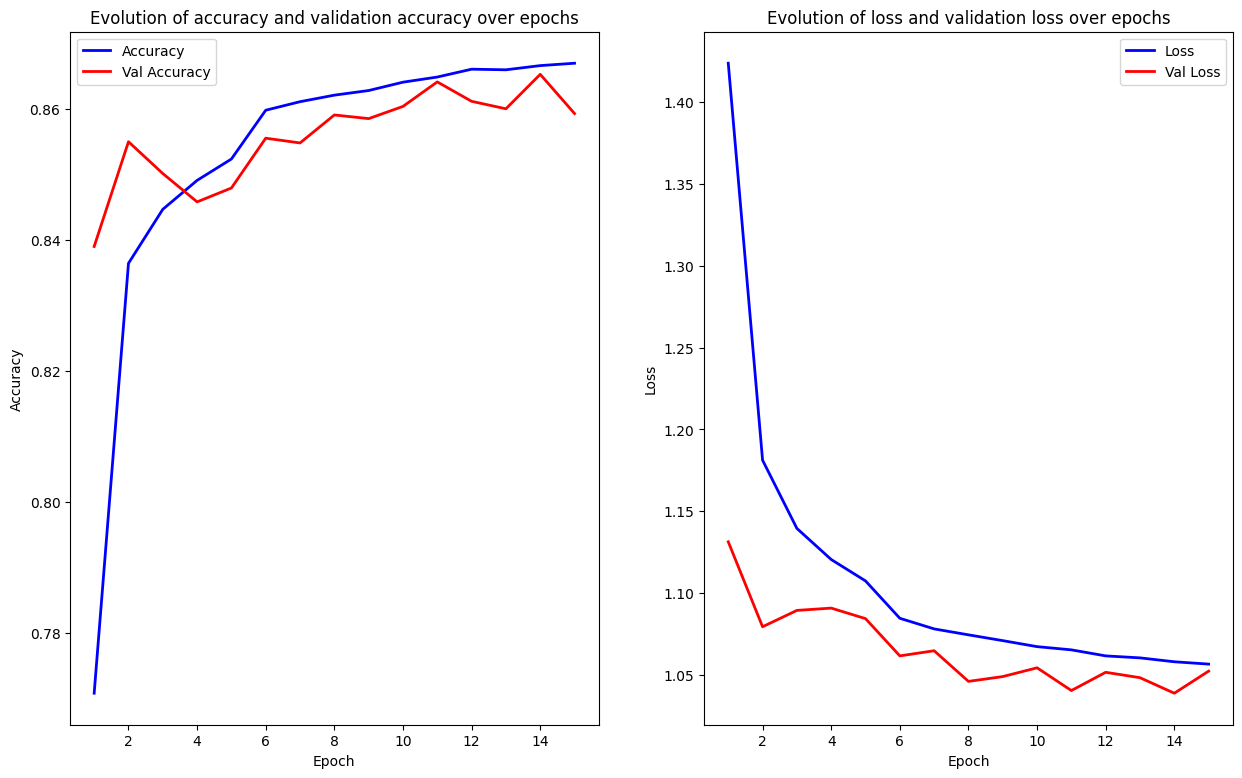

In [46]:
def plot_data_by_epoch(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    loss = history.history['loss']
    v_loss = history.history['val_loss']
    acc = history.history['accuracy']
    v_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(1, 2, figsize=(15,9))
    ax[0].plot(epochs, acc, 'b-', linewidth=2, label='Accuracy')
    ax[0].plot(epochs, v_acc, 'r-', linewidth=2, label='Val Accuracy')
    ax[0].set_title('Evolution of accuracy and validation accuracy over epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')
    
    ax[1].plot(epochs, loss, 'b-', linewidth=2, label='Loss')
    ax[1].plot(epochs, v_loss, 'r-', linewidth=2, label='Val Loss')
    ax[1].set_title('Evolution of loss and validation loss over epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')
    plt.show()

plot_data_by_epoch(history)

We can see that we might experience marginal improvements if we let the model run for more epochs. If needed, we can fine tune the model as needed. Lets see the accuracy and the confusion matrix of our model on the test data.

3636/3636 [==============================] - 14s 4ms/step


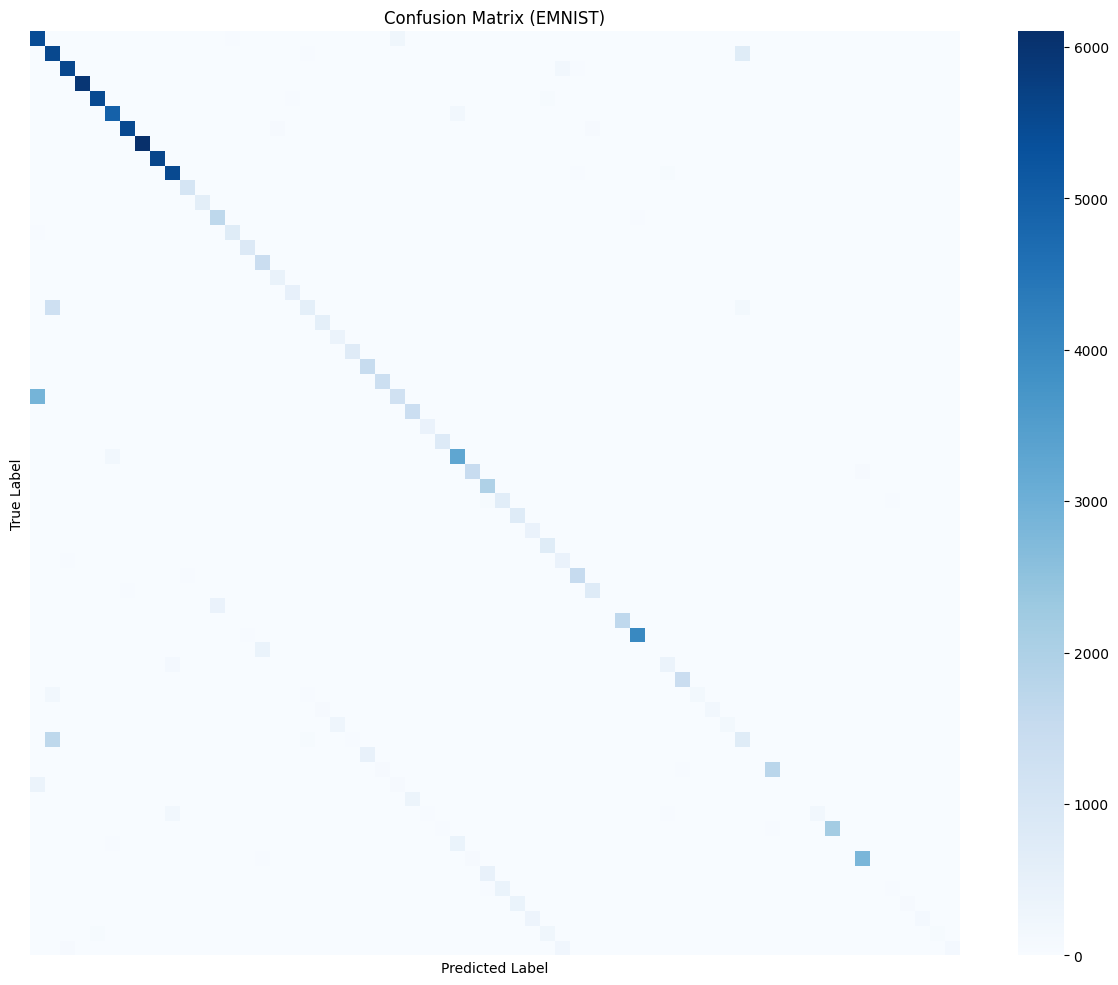

              precision    recall  f1-score   support

           0       0.62      0.94      0.75      5778
           1       0.64      0.88      0.74      6330
           2       0.98      0.95      0.96      5869
           3       0.99      1.00      1.00      5969
           4       0.98      0.98      0.98      5619
           5       0.95      0.95      0.95      5190
           6       0.99      0.97      0.98      5705
           7       0.99      0.99      0.99      6139
           8       0.99      0.99      0.99      5633
           9       0.93      0.97      0.95      5686
          10       0.96      0.99      0.98      1062
          11       0.95      0.99      0.97       648
          12       0.77      0.97      0.86      1739
          13       0.91      0.93      0.92       779
          14       0.96      0.99      0.97       851
          15       0.76      0.99      0.86      1440
          16       0.76      0.97      0.85       447
          17       0.90    

C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\georgelour\miniconda3\envs\testEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [47]:
def test_model(model, test_dataset):
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
    y_true = y_test.argmax(axis=1)  # Convert one-hot labels back to class labels

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (EMNIST)')
    plt.show()
    
    print(classification_report(y_true, y_pred_classes))

test_model(model, test_dataset)

We can see we have an average accuracy of 86%, which is acceptable for our needs. We recognize that we struggle to identify specific classes, in some cases not detecting them at all!! Hence the warning below the code. For now, we will keep the model and we will check if the language model that we will create is sufficient to identify and correct all the errors of our translation. If it cannot, we will modify, or even use a pretrained model in order to nullify this problem. We save the model and proceed to the identifying of text characters and digits.

In [50]:
model.save("text_model.keras")

<h2>Part 2: Retrieving, clearing, upsampling and translating an image.</h2>

The most important part is to extract the image and process it in such a way that we keep the maximum amount of detail.

In [10]:
def filter_image(image, option='b'):
    if(len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    if(option == 'b'):
        return cv.bilateralFilter(image, 9, 9, 75)
    elif(option == 'm'):
        return cv.medianBlur(image, 3)
    elif(option == 'b+m'):
        image = cv.medianBlur(image, 3)
        return cv.bilateralFilter(image, 15, 9, 75)
    else:
        print('Uknown type of filter!')

We filter the image to first remove what noise we can without it being too computationally expensive. Note that we give multiple options in case an image contains different types of noise.

In [11]:
def correct_illumination(image, kernel_size=5):
    float_image = image.astype(np.float32)
    
    illumination = cv.GaussianBlur(float_image, (kernel_size, kernel_size), 0)
    illumination[illumination == 0] = 1
    corrected = float_image / illumination * np.mean(illumination)
    
    corrected = np.clip(corrected, 0, 255).astype(np.uint8)
    return corrected

We then equalize the illumination. That will be quite beneficial because the brightness will equalize in all our image, so we can extract info easier. We also give an option to increase kernel size in case the correction is too strong, leading to blurry images.

In [386]:
def prepare_image(image, filter_option='m', illumination_kernel=5, bright_thresh=90):
    if(len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    if(bright_thresh is not None):
        image = np.where(image > bright_thresh, 255, 0).astype(np.uint8)
    image = filter_image(image, option=filter_option)
    
    image = correct_illumination(image, kernel_size=illumination_kernel)
    image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 31, 10)

    
    kernel = np.ones((1,1), np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    image = cv.erode(image, kernel, iterations=1)
    return image

def invert_image(image):
    return (255-image)

We then prepare the image in order to feed it to our processor. We filter it, correct lighting and threshold it. As we want to have an option to clearly see the text we work on, we also add a function that inverts the image. That way, we can properly see the cleared image and its quality.

In [388]:
def resize_image(image, size=(28, 28)):
    h, w = image.shape
    scale = min(size[0] / h, size[1] / w)
    w, h = int(w * scale), int(h * scale)
    
    image = cv.resize(image, (w, h), interpolation=cv.INTER_LANCZOS4)
    
    final_image = np.zeros(size, dtype=np.uint8)
    center_x = (size[1] - w) // 2
    center_y = (size[0] - h) // 2
    final_image[center_y:center_y+h, center_x:center_x + w] = image
    return image

We then need a function that can properly resize an image, keeping the proper scaling options. Our model will only accept 28 by 28 images, so we need to accomodate for that.

We now create a function that will connect close contours, in case a letter is segmented in two or if the letter is not identified fully.

In [486]:
def get_text_images(image, size=(28, 28), filter_option='b', img_threshold=50, line_threshold=20, upscaling_factor=1.0, illumination_kernel=5, contour_merge=10, bright_thresh=90):
    image = cv.resize(image, None, fx=upscaling_factor, fy=upscaling_factor, interpolation=cv.INTER_LANCZOS4)
    processed_image = prepare_image(image, filter_option=filter_option, illumination_kernel=illumination_kernel, bright_thresh=bright_thresh)
    showcase_image = processed_image.copy()
    showcase_image = invert_image(showcase_image)
    showcase_image = cv.cvtColor(showcase_image, cv.COLOR_GRAY2BGR)
    clear_image = showcase_image.copy()
    images = []
    bounding_rects = []
    _, contours, _ = cv.findContours(processed_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if(w * h > img_threshold):
            bounding_rects.append([x, y, w, h])
    bounding_rects.sort(key=lambda b:b[1])
    
    rows = []
    row = [bounding_rects[0]]
    for i in range(1, len(bounding_rects)):
        x, y, w, h = bounding_rects[i]
        _, prev_y, _, prev_h = row[-1]
        if(abs(y - prev_y) <= line_threshold) or (abs(y + h - prev_h - prev_y)) <= line_threshold:
            row.append(bounding_rects[i])
        else:
            rows.append(row)
            row = []
            row.append(bounding_rects[i])

    if row:
        rows.append(row)

    row_data = []
    for row in rows:
        x1 = min(row, key= lambda x: x[0])[0]
        x2 = max(row, key=lambda x: x[0])[0] + max(row, key=lambda x: x[0])[2]
        y1 = min(row, key=lambda x:x[1])[1]
        y2 = max(row, key=lambda x:x[1])[1] + max(row, key=lambda x:x[1])[3]
        cv.rectangle(showcase_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        row_data.append([x1, y1, x2, y2])
    return row_data, image, showcase_image, clear_image

Finally, we put it all together. We process the image, we extract each letter from our image and we return both the letter and its bounding boxes. Have in mind the multiple factors that we add. Because each image is different and has different types of noise, clarity, blur etc we make sure to make all values able to be changed. Also, for the contours, we extract and group them in lines.

Now lets see an example.

<Figure size 1000x1000 with 0 Axes>

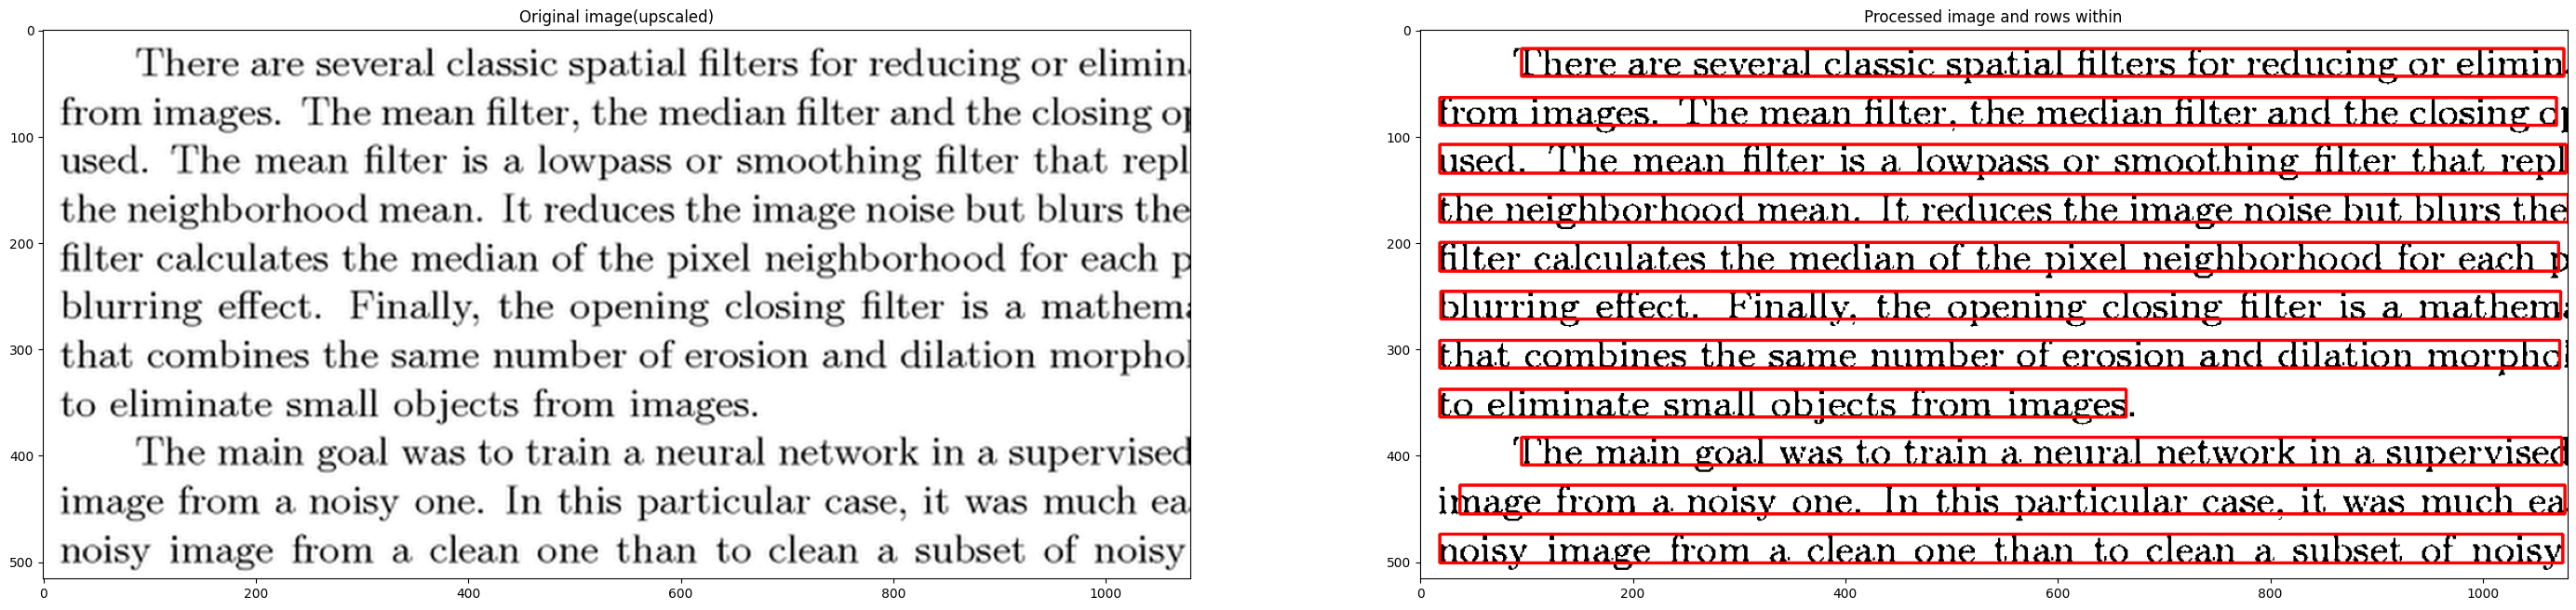

In [489]:
image = cv.imread('testimage3.png')
rows, upscaled_image, showcase_image, _ = get_text_images(image, size=(28, 28), filter_option='b', img_threshold=150, line_threshold=10, upscaling_factor=2.0, illumination_kernel=5, contour_merge=15, bright_thresh=160)
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(1, 2, figsize=(35, 35))
ax[0].imshow(upscaled_image)
ax[0].set_title('Original image(upscaled)')
ax[1].imshow(showcase_image)
ax[1].set_title('Processed image and rows within')
plt.show()

We can see we both clear the noise from the image AND we identify the text rows almost perfectly. Now lets see if it holds up against our other test images.

<Figure size 500x500 with 0 Axes>

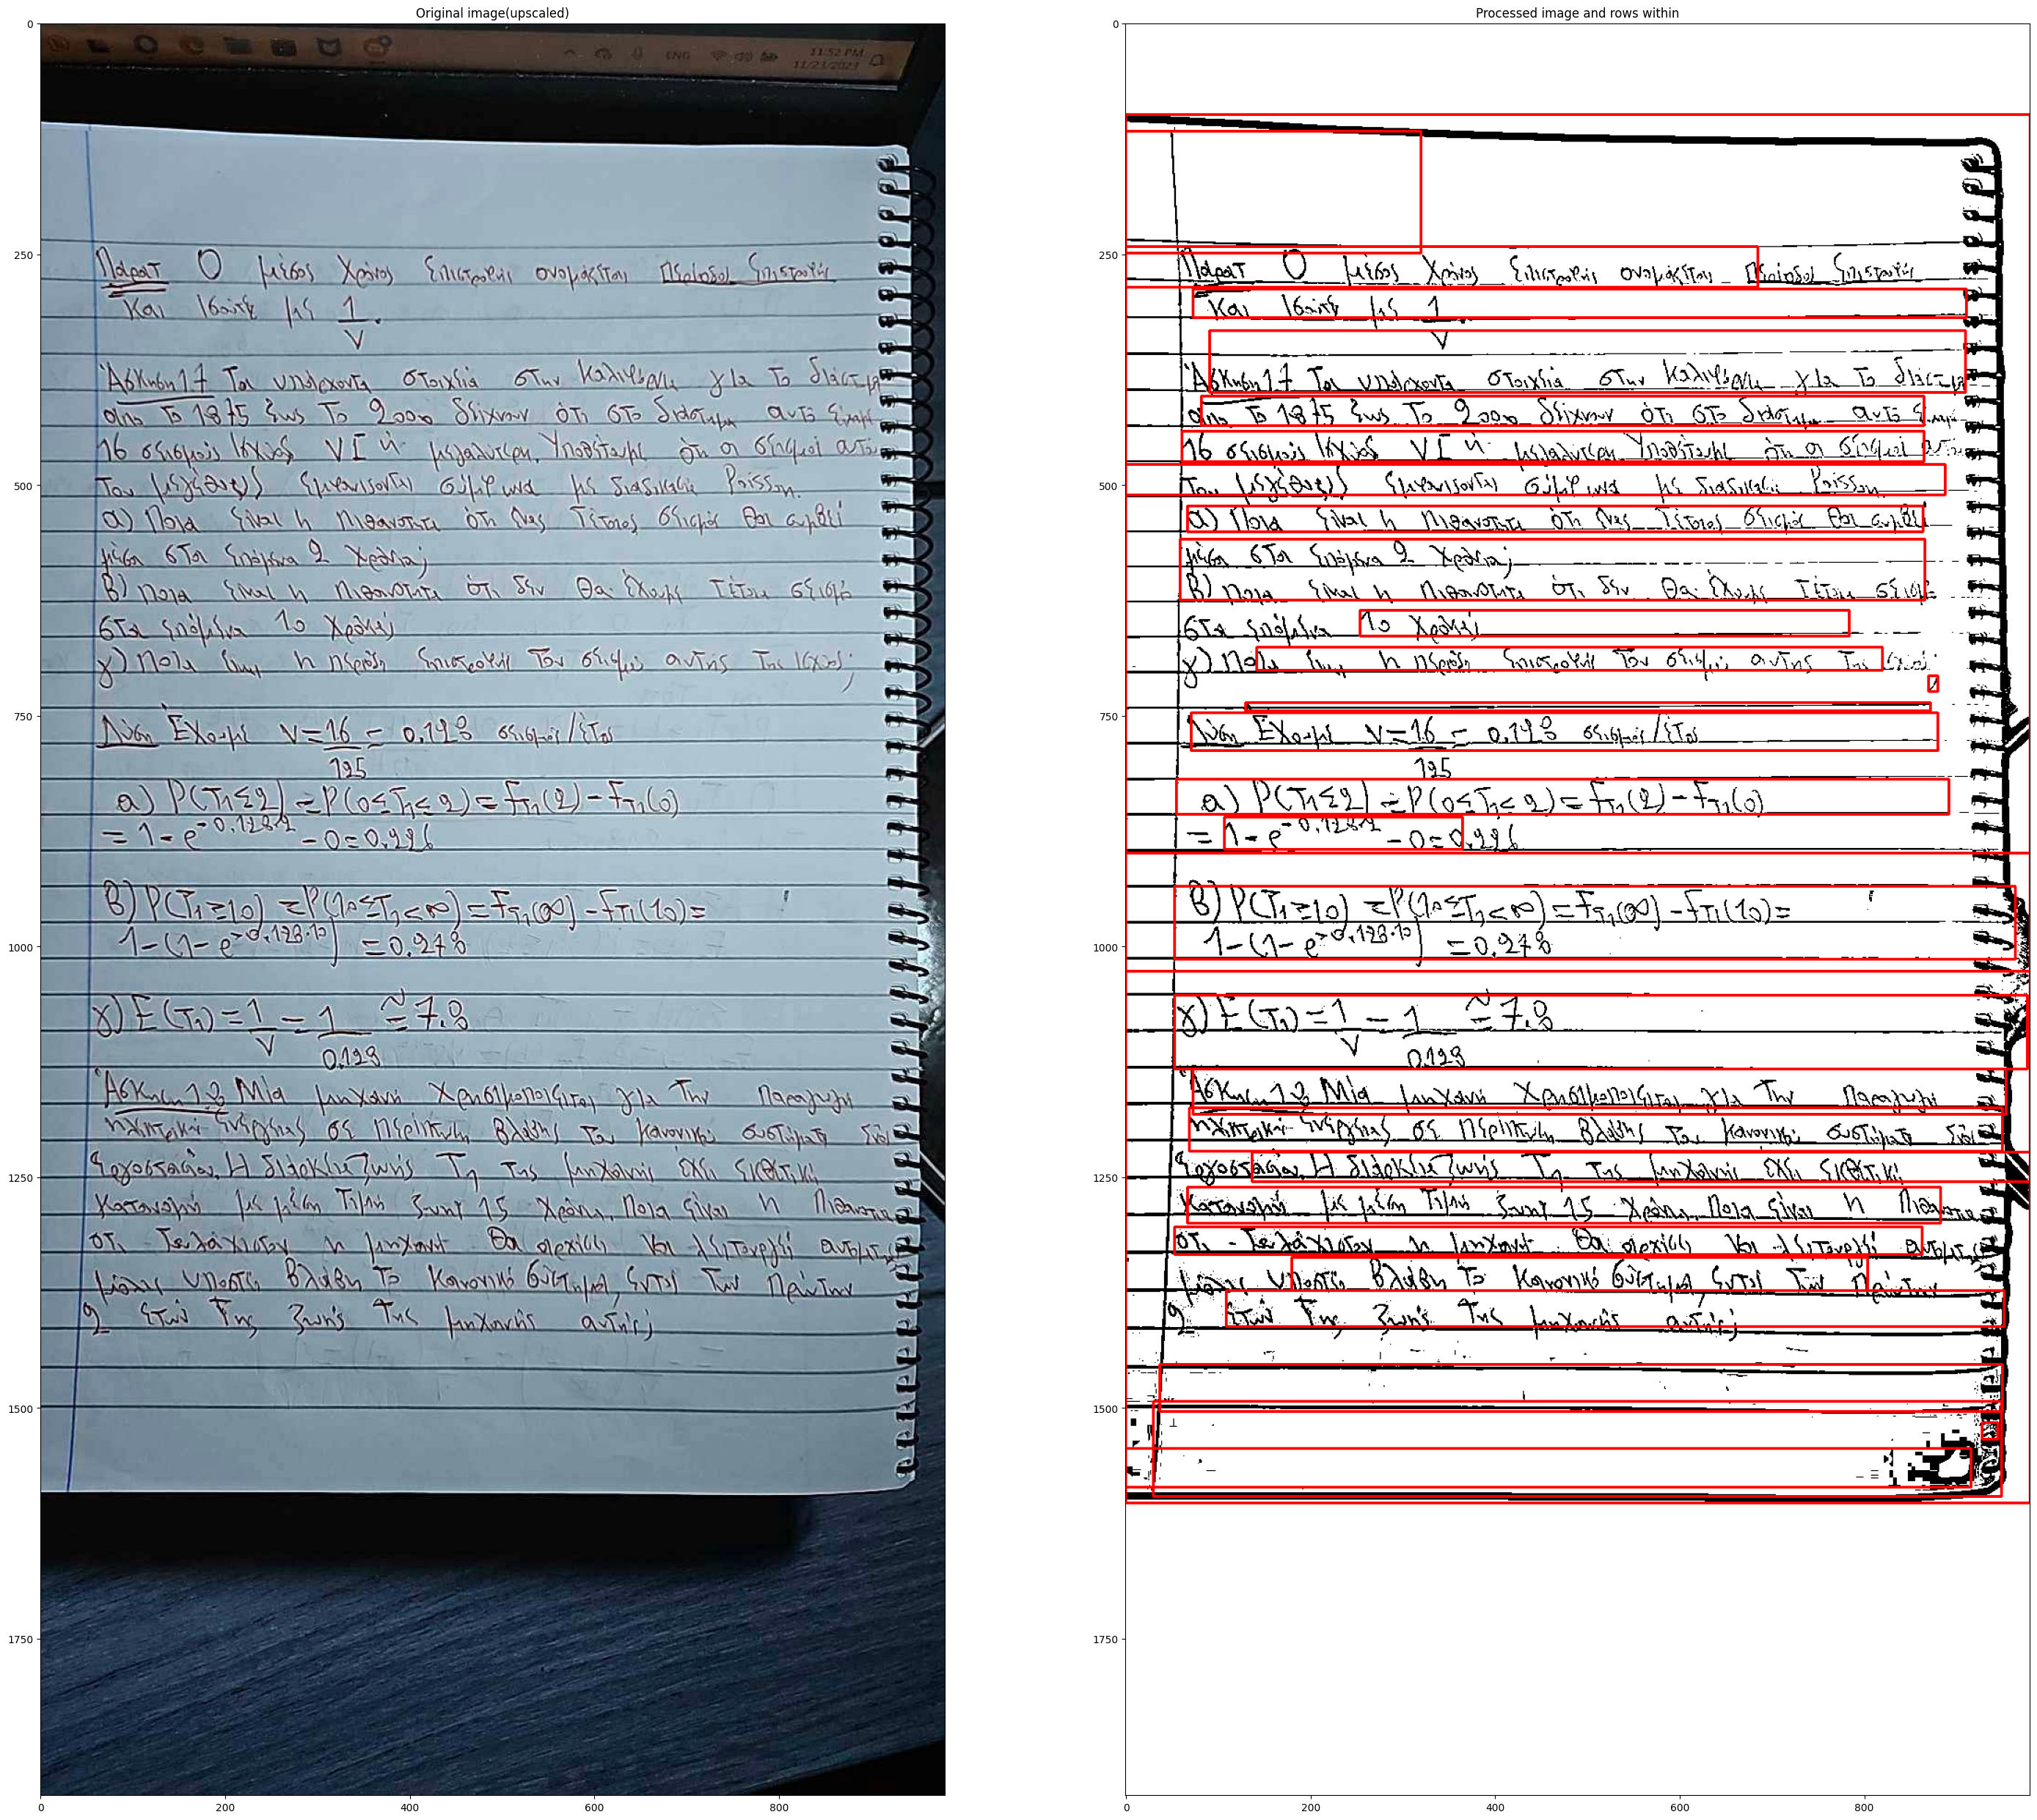

In [491]:
image = cv.imread('testimage3.png')
image = cv.imread('testimage.jpg')
rows, upscaled_image, showcase_image, _ = get_text_images(image, size=(28, 28), filter_option='b', img_threshold=150, line_threshold=10, upscaling_factor=1.0, illumination_kernel=5, contour_merge=15, bright_thresh=130)
plt.figure(figsize=(5, 5))
fig, ax = plt.subplots(1, 2, figsize=(35, 35))
ax[0].imshow(upscaled_image)
ax[0].set_title('Original image(upscaled)')
ax[1].imshow(showcase_image)
ax[1].set_title('Processed image and rows within')
plt.show()

The result, despite not perfect, could be considered passable. The greatest offender here are the textbook's lines, obscuring the row detection method massively.  On the positive side, the readability of the document is quite good.

<Figure size 1000x1000 with 0 Axes>

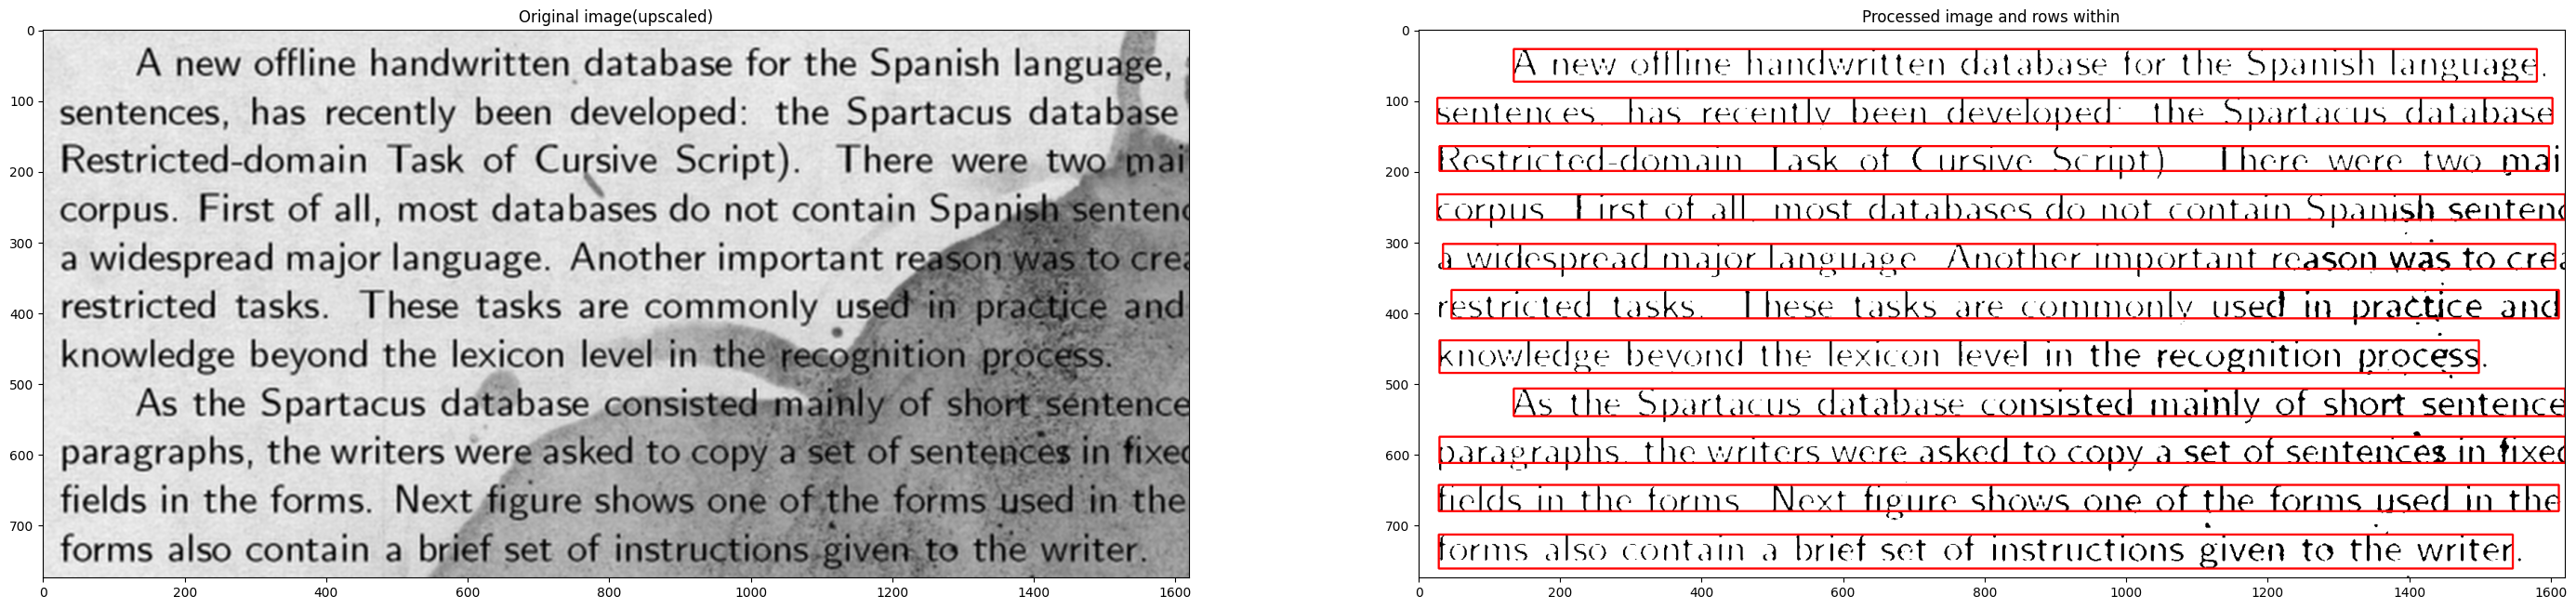

In [492]:
image = cv.imread('testimage2.png')
rows, upscaled_image, showcase_image, cleared_image = get_text_images(image, size=(28, 28), filter_option='b', img_threshold=150, line_threshold = 20, upscaling_factor=3.0, illumination_kernel=5, contour_merge=15, bright_thresh=60)
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(1, 2, figsize=(35, 35))
ax[0].imshow(upscaled_image)
ax[0].set_title('Original image(upscaled)')
ax[1].imshow(showcase_image)
ax[1].set_title('Processed image and rows within')
plt.show()

Another great result. Lets now test our function in a very hard-to-read document with more background noise.

Note that we changed some values slightly. Trying the same values will not yield acceptable results. This is the reason we added so many options to the get_text_images function! Sometimes the contours may be too close up, sometimes the image will not need upscaling, maybe another filter will be more efficient at noise removal etc... If we process each image individually we can extract a ton of lossless info.

Before we proceed with the language model, lets test if the image is readable enough using common libraries such as pytesseract. Pytesserct has quite a low accuracy percentage (~20%), so we will not expect a great result. We will use it as a test to see if our test has become readable enough.

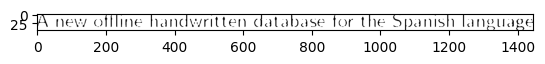

In [553]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Apps/Tesseract-OCR/tesseract.exe'

row = rows[0]
sample_data = cleared_image[row[1]:row[3], row[0]:row[2]]
plt.imshow(sample_data)

This is how we will feed each row to pytesserct. Lets now try to use it!

In [549]:
final_message = ''
for row in rows:
    current_image = cleared_image[row[1]:row[3], row[0]:row[2]]
    final_message = final_message + pytesseract.image_to_string(current_image) + os.linesep

print(final_message)

A new offline handwritten database for the Spanish language

sentences has recently been develoned: the Spartacus database

Reactricted-domain flask of Cursive Script) | here were two m2

corpus burst of all most databases do not contatn Spanish sentenc

ywidespread maror laneciace Another mmoortant reason was to cre

estricted tasks |hese tasks are commonly used tn practice and

Knowledge beyond the lexicon level in the recognition process

As the Spartacus database consisted mamnlv of short sentence

jyorgceraphs the writers were askec| to conv 3 set of sentencez in ftrxec

fialdls in the forms Next froure shovwss one of the formes tised in the

forms also contain a brief set of instructions given to the writer




A very promising result. Aside from a few small errors the text is very good!

<h2>Part 3: Creating a language model to correct errors.</h2>